In [ ]:
import xarray as xr
import fsspec
import cartopy.crs as ccrs
import matplotlib.pyplot as plt 
import scipy.spatial
import numpy as np
%load_ext autoreload
%autoreload 1 

%aimport src
import geopandas as gpd 
import os
from pathlib import Path
notebook_path = os.getcwd()
data_path = Path(notebook_path).parent / 'data' / 'geographic' / 'cb_2018_us_county_500k.shp'

In [15]:

fs = fsspec.filesystem('gs')
fs.ls('gs://gcp-public-data-arco-era5/co/')

['gcp-public-data-arco-era5/co/model-level-moisture.zarr',
 'gcp-public-data-arco-era5/co/model-level-moisture.zarr-v2',
 'gcp-public-data-arco-era5/co/model-level-wind.zarr',
 'gcp-public-data-arco-era5/co/model-level-wind.zarr-v2',
 'gcp-public-data-arco-era5/co/single-level-forecast.zarr',
 'gcp-public-data-arco-era5/co/single-level-forecast.zarr-v2',
 'gcp-public-data-arco-era5/co/single-level-reanalysis.zarr',
 'gcp-public-data-arco-era5/co/single-level-reanalysis.zarr-v2',
 'gcp-public-data-arco-era5/co/single-level-surface.zarr',
 'gcp-public-data-arco-era5/co/single-level-surface.zarr-v2']

In [19]:

ds = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/co/single-level-reanalysis.zarr-v2',
    # chunks=None,
    chunks={'time': 48},
    storage_options=dict(token='anon'),
    consolidated=True,
)
ar_full_37_1h = ds.sel(time=slice(ds.attrs['valid_time_start'], ds.attrs['valid_time_stop']))
example = ar_full_37_1h.sel(time=slice("2022-01-01", "2022-01-02")).compute()



/tmp/ipykernel_178544/3793866363.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_zarr(
/tmp/ipykernel_178544/3793866363.py:1: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 48. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_zarr(


In [20]:
print(f'size: {example.nbytes / (1024 ** 4)} TiB')   

size: 0.003604954843467567 TiB


In [ ]:

def lon_to_360(dlon: float) -> float:
  return ((360 + (dlon % 360)) % 360)


def roll_longitude(ds):
    return ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')

US_ds = example.where(
    (example.longitude > lon_to_360(-171.79)) & (example.latitude > 18.91) &
    (example.longitude < lon_to_360(-66.96)) & (example.latitude < 71.35),
    drop=True
)
US_ds

<xarray.Dataset> Size: 363MB
Dimensions:              (time: 48, values: 49625)
Coordinates:
    depthBelowLandLayer  float64 8B 100.0
    entireAtmosphere     float64 8B 0.0
    latitude             (values) float64 397kB 71.24 71.24 ... 18.97 18.97
    longitude            (values) float64 397kB 188.3 189.2 ... 292.5 292.8
    number               int64 8B 0
    step                 timedelta64[ns] 8B 00:00:00
    surface              float64 8B 0.0
  * time                 (time) datetime64[ns] 384B 2022-01-01 ... 2022-01-02...
    valid_time           (time) datetime64[ns] 384B 2022-01-01 ... 2022-01-02...
Dimensions without coordinates: values
Data variables: (12/38)
    cape                 (time, values) float32 10MB 0.25 0.75 1.875 ... 0.0 0.0
    d2m                  (time, values) float32 10MB 246.4 246.2 ... 291.9 291.7
    hcc                  (time, values) float32 10MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    istl1                (time, values) float32 10MB 248.3 248.1 ... 271.5 271.5
    istl2                (time, values) float32 10MB 248.9 248.8 ... 271.5 271.5
    istl3                (time, values) float32 10MB 256.0 255.9 ... 271.5 271.5
    ...                   ...
    tsn                  (time, values) float32 10MB 249.0 248.8 ... 300.4 300.4
    u10                  (time, values) float32 10MB -0.676 -0.5334 ... -7.481
    u100                 (time, values) float32 10MB -2.012 -1.793 ... -8.282
    v10                  (time, values) float32 10MB -4.744 -4.904 ... -1.978
    v100                 (time, values) float32 10MB -6.634 -6.984 ... -2.132
    z                    (time, values) float32 10MB -5.391 3.84 ... 4.285
Attributes: (12/14)
    Conventions:               CF-1.7
    GRIB_centre:               ecmf
    GRIB_centreDescription:    European Centre for Medium-Range Weather Forec...
    GRIB_edition:              1
    GRIB_subCentre:            0
    history:                   2023-08-27T15:04 GRIB to CDM+CF via cfgrib-0.9...
    ...                        ...
    pangeo-forge:inputs_hash:  89c3caaaaf19eb0f6e9749dbde6c93972d64419137e2c8...
    pangeo-forge:recipe_hash:  09c22f5fffc2fbe3742fbb38c8c2c761e1b41b50570f09...
    pangeo-forge:version:      0.9.5.dev2+gd43015b
    valid_time_start:          1940-01-01
    valid_time_stop:           2025-01-31
    valid_time_stop_era5t:     2025-03-31

<xarray.Dataset> Size: 363MB
Dimensions:              (time: 48, values: 49625)
Coordinates:
    depthBelowLandLayer  float64 8B 100.0
    entireAtmosphere     float64 8B 0.0
    latitude             (values) float64 397kB 71.24 71.24 ... 18.97 18.97
    longitude            (values) float64 397kB 188.3 189.2 ... 292.5 292.8
    number               int64 8B 0
    step                 timedelta64[ns] 8B 00:00:00
    surface              float64 8B 0.0
  * time                 (time) datetime64[ns] 384B 2022-01-01 ... 2022-01-02...
    valid_time           (time) datetime64[ns] 384B 2022-01-01 ... 2022-01-02...
Dimensions without coordinates: values
Data variables: (12/38)
    cape                 (time, values) float32 10MB 0.25 0.75 1.875 ... 0.0 0.0
    d2m                  (time, values) float32 10MB 246.4 246.2 ... 291.9 291.7
    hcc                  (time, values) float32 10MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    istl1                (time, values) float32 10MB 248.3 248.1 ... 271.5 271.5
    istl2                (time, values) float32 10MB 248.9 248.8 ... 271.5 271.5
    istl3                (time, values) float32 10MB 256.0 255.9 ... 271.5 271.5
    ...                   ...
    tsn                  (time, values) float32 10MB 249.0 248.8 ... 300.4 300.4
    u10                  (time, values) float32 10MB -0.676 -0.5334 ... -7.481
    u100                 (time, values) float32 10MB -2.012 -1.793 ... -8.282
    v10                  (time, values) float32 10MB -4.744 -4.904 ... -1.978
    v100                 (time, values) float32 10MB -6.634 -6.984 ... -2.132
    z                    (time, values) float32 10MB -5.391 3.84 ... 4.285
Attributes: (12/14)
    Conventions:               CF-1.7
    GRIB_centre:               ecmf
    GRIB_centreDescription:    European Centre for Medium-Range Weather Forec...
    GRIB_edition:              1
    GRIB_subCentre:            0
    history:                   2023-08-27T15:04 GRIB to CDM+CF via cfgrib-0.9...
    ...                        ...
    pangeo-forge:inputs_hash:  89c3caaaaf19eb0f6e9749dbde6c93972d64419137e2c8...
    pangeo-forge:recipe_hash:  09c22f5fffc2fbe3742fbb38c8c2c761e1b41b50570f09...
    pangeo-forge:version:      0.9.5.dev2+gd43015b
    valid_time_start:          1940-01-01
    valid_time_stop:           2025-01-31
    valid_time_stop_era5t:     2025-03-31

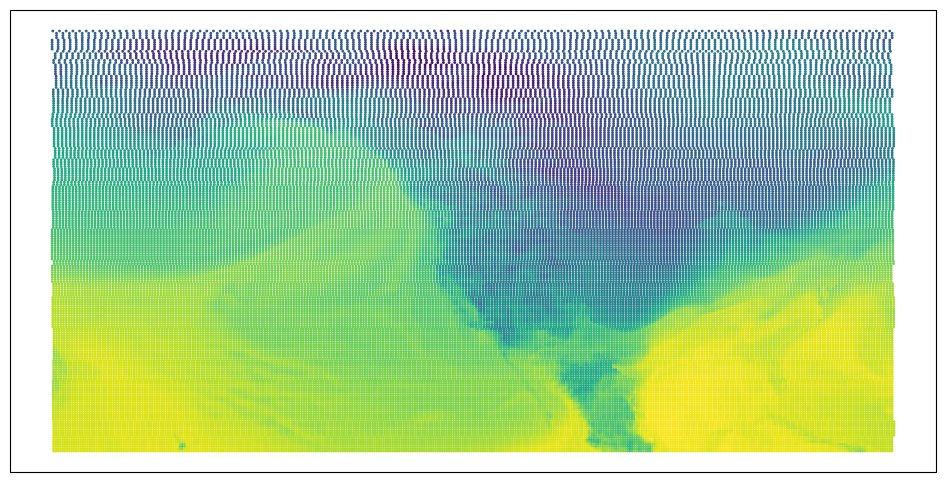

In [ ]:
plt.figure(figsize=(12, 6))
plt.axes(projection=ccrs.PlateCarree())
plt.scatter(
    US_ds.longitude,
    US_ds.latitude,
    c=US_ds.d2m.sel(time='2022-01-01T18').values,
    s=1,
)
US_ds

In [ ]:

def mirror_point_at_360(ds):
  extra_point = (
      ds.where(ds.longitude == 0, drop=True)
      .assign_coords(longitude=lambda x: x.longitude + 360)
  )
  return xr.concat([ds, extra_point], dim='values')

def build_triangulation(x, y):
  grid = np.stack([x, y], axis=1)
  return scipy.spatial.Delaunay(grid)

def interpolate(data, tri, mesh):
  indices = tri.find_simplex(mesh)
  ndim = tri.transform.shape[-1]
  T_inv = tri.transform[indices, :ndim, :]
  r = tri.transform[indices, ndim, :]
  c = np.einsum('...ij,...j', T_inv, mesh - r)
  c = np.concatenate([c, 1 - c.sum(axis=-1, keepdims=True)], axis=-1)
  result = np.einsum('...i,...i', data[:, tri.simplices[indices]], c)
  return np.where(indices == -1, np.nan, result)

In [ ]:
counties = gpd.read_file(data_path)
# Compute county centroids
county_centroids = counties.geometry.centroid
counties['centroid'] = county_centroids

# Extract latitude and longitude of centroids
centroid_coords = np.array([[lon_to_360(point.x), point.y] for point in county_centroids])


/tmp/ipykernel_178544/601899103.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  county_centroids = counties.geometry.centroid


In [49]:

centroid_coords

array([[271.00074411,  37.05848196],
       [275.78284943,  38.20673452],
       [273.31837666,  37.2072845 ],
       ...,
       [261.05344516,  30.31803705],
       [272.0332282 ,  43.00719657],
       [274.00389887,  42.95984867]], shape=(3233, 2))

In [54]:
%time tri = build_triangulation(US_ds.longitude, US_ds.latitude)

CPU times: user 182 ms, sys: 0 ns, total: 182 ms
Wall time: 181 ms


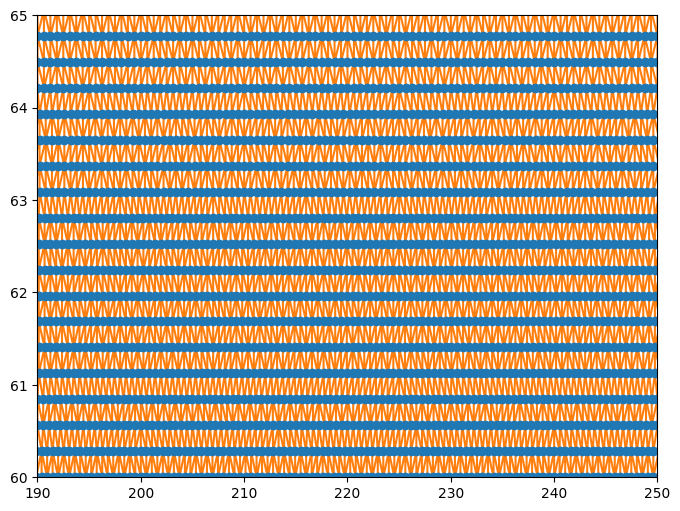

In [61]:

# near the north pole
scipy.spatial.delaunay_plot_2d(tri)
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.xlim(190,250)
_ = plt.ylim(60, 65)


In [73]:
%time d2m_mesh = interpolate(US_ds.d2m.values, tri, centroid_coords)

CPU times: user 5.95 ms, sys: 0 ns, total: 5.95 ms
Wall time: 5.45 ms


In [83]:
US_ds_regrid = xr.DataArray(
    d2m_mesh,
    coords={
        "time": US_ds.time.data,
        "centroid": np.arange(d2m_mesh.shape[1]),
        "longitude": ("centroid", centroid_coords[:, 0]),
        "latitude": ("centroid", centroid_coords[:, 1]),
    },
    dims=["time", "centroid"]
)

In [85]:
US_ds_regrid 

<xarray.DataArray (time: 48, centroid: 3233)> Size: 1MB
array([[289.11843363, 286.84155546, 289.14971993, ..., 289.46913467,
        273.28791224, 273.10546848],
       [289.17004666, 287.94294353, 288.99351749, ..., 289.46135592,
        273.53757337, 273.27873941],
       [289.87681916, 288.30395167, 289.20518846, ..., 289.50192362,
        273.21161254, 273.47305602],
       ...,
       [267.77194284, 272.75062557, 271.62117898, ..., 262.90157551,
        260.89878905, 264.1816842 ],
       [267.87538475, 271.59057787, 271.26718349, ..., 263.03375375,
        261.62250724, 263.74460108],
       [267.75475948, 270.85576569, 271.24987853, ..., 262.73235197,
        261.3492492 , 263.58714533]], shape=(48, 3233))
Coordinates:
  * time       (time) datetime64[ns] 384B 2022-01-01 ... 2022-01-02T23:00:00
  * centroid   (centroid) int64 26kB 0 1 2 3 4 5 ... 3228 3229 3230 3231 3232
    longitude  (centroid) float64 26kB 271.0 275.8 273.3 ... 261.1 272.0 274.0
    latitude   (centroid) float64 26kB 37.06 38.21 37.21 ... 30.32 43.01 42.96

In [87]:
US_ds_regrid[0]

<xarray.DataArray (centroid: 3233)> Size: 26kB
array([289.11843363, 286.84155546, 289.14971993, ..., 289.46913467,
       273.28791224, 273.10546848], shape=(3233,))
Coordinates:
    time       datetime64[ns] 8B 2022-01-01
  * centroid   (centroid) int64 26kB 0 1 2 3 4 5 ... 3228 3229 3230 3231 3232
    longitude  (centroid) float64 26kB 271.0 275.8 273.3 ... 261.1 272.0 274.0
    latitude   (centroid) float64 26kB 37.06 38.21 37.21 ... 30.32 43.01 42.96

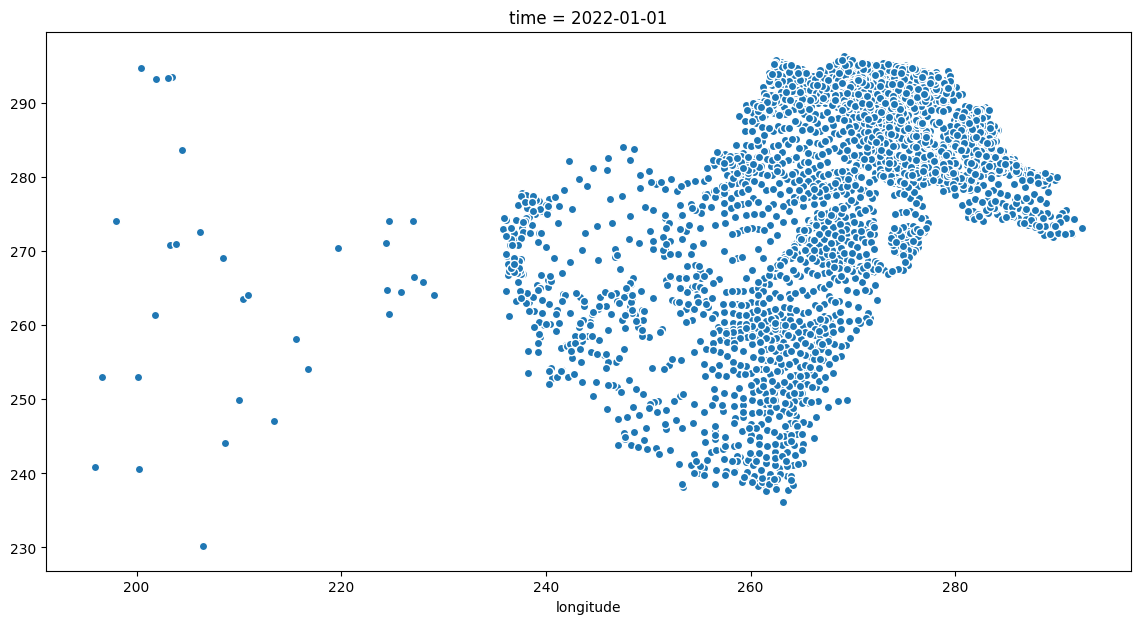

In [97]:
US_ds_regrid[0].plot.scatter(
	x='longitude', 
	# y='latitude', 
	cmap='viridis', 
	size=7, 
	aspect=2, 
	add_colorbar=False
)

In [24]:


def attribute_fix(ds):
    """Needed to fix a low-level bug in ecCodes.
    
    Sometimes, shortNames get overloaded in ecCodes's table. 
    To eliminate ambiguity in their string matching, we
    force ecCodes to make use of the paramId, which is a
    consistent source-of-truth.
    """
    for var in ds:
        attrs = ds[var].attrs
        result = attrs.pop('GRIB_cfName', None)
        result = attrs.pop('GRIB_cfVarName', None)
        result = attrs.pop('GRIB_shortName', None)
        ds[var].attrs.update(attrs)
    return ds



     
